# Hodgkin-Huxley Model Simulation for Action Potential

## Yêu cầu đề bài

**Requirement:** Định nghĩa tất cả các tham số cần thiết và 6 hàm tốc độ (α_x, β_x) của các kênh ion.

- Sử dụng điện thế màng ban đầu: **V₀ = -65 mV**
- Áp dụng dòng điện đầu vào **I_x**: Step Input với biên độ **20 μA/cm²**

**Kết quả cần:**
1. Vẽ biểu đồ điện thế màng (V), dòng Sodium (I_Na), và dòng Potassium (I_K) theo thời gian
2. Giải thích vai trò của I_Na và I_K trong quá trình khử cực (depolarization) và tái phân cực (repolarization)

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Cấu hình matplotlib
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
""" 
============================================================================
PHẦN 1: ĐỊNH NGHĨA CÁC THAM SỐ CỦA MÔ HÌNH HODGKIN-HUXLEY
============================================================================
"""

print("="*80)
print("HODGKIN-HUXLEY MODEL - ACTION POTENTIAL SIMULATION")
print("="*80)
print()

# Tham số của màng tế bào
C_m = 1.0       # Điện dung màng (μF/cm²)
g_Na = 120.0    # Độ dẫn tối đa của kênh Sodium (mS/cm²)
g_K = 36.0      # Độ dẫn tối đa của kênh Potassium (mS/cm²)
g_L = 0.3       # Độ dẫn của dòng rò (mS/cm²)

# Điện thế đảo (reversal potentials)
E_Na = 50.0     # Điện thế đảo của Sodium (mV)
E_K = -77.0     # Điện thế đảo của Potassium (mV)
E_L = -54.387   # Điện thế đảo của dòng rò (mV)

# Điện thế màng ban đầu (theo yêu cầu đề bài)
V_0 = -65.0     # mV

# Dòng điện đầu vào (theo yêu cầu đề bài)
I_ext = 20.0    # Step Input với biên độ 20 μA/cm²

print("THAM SỐ MÔ HÌNH:")
print(f"  - Điện dung màng (C_m): {C_m} μF/cm²")
print(f"  - Độ dẫn Na (g_Na): {g_Na} mS/cm²")
print(f"  - Độ dẫn K (g_K): {g_K} mS/cm²")
print(f"  - Độ dẫn rò (g_L): {g_L} mS/cm²")
print(f"  - Điện thế đảo Na (E_Na): {E_Na} mV")
print(f"  - Điện thế đảo K (E_K): {E_K} mV")
print(f"  - Điện thế đảo rò (E_L): {E_L} mV")
print(f"  - Điện thế màng ban đầu (V₀): {V_0} mV")
print(f"  - Dòng điện ngoài (I_ext): {I_ext} μA/cm²")
print()

HODGKIN-HUXLEY MODEL - ACTION POTENTIAL SIMULATION

THAM SỐ MÔ HÌNH:
  - Điện dung màng (C_m): 1.0 μF/cm²
  - Độ dẫn Na (g_Na): 120.0 mS/cm²
  - Độ dẫn K (g_K): 36.0 mS/cm²
  - Độ dẫn rò (g_L): 0.3 mS/cm²
  - Điện thế đảo Na (E_Na): 50.0 mV
  - Điện thế đảo K (E_K): -77.0 mV
  - Điện thế đảo rò (E_L): -54.387 mV
  - Điện thế màng ban đầu (V₀): -65.0 mV
  - Dòng điện ngoài (I_ext): 20.0 μA/cm²



In [3]:
"""
============================================================================
PHẦN 2: ĐỊNH NGHĨA 6 HÀM TỐC ĐỘ (α_x, β_x) CHO CÁC KÊNH ION
============================================================================
"""

print("="*80)
print("ĐỊNH NGHĨA 6 HÀM TỐC ĐỘ (Rate Functions)")
print("="*80)
print()

def alpha_m(V):
    """Hàm tốc độ mở của cổng kích hoạt kênh Sodium (m-gate)"""
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    """Hàm tốc độ đóng của cổng kích hoạt kênh Sodium (m-gate)"""
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    """Hàm tốc độ mở của cổng bất hoạt kênh Sodium (h-gate)"""
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    """Hàm tốc độ đóng của cổng bất hoạt kênh Sodium (h-gate)"""
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    """Hàm tốc độ mở của cổng kích hoạt kênh Potassium (n-gate)"""
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    """Hàm tốc độ đóng của cổng kích hoạt kênh Potassium (n-gate)"""
    return 0.125 * np.exp(-(V + 65.0) / 80.0)

print("Đã định nghĩa 6 hàm tốc độ:")
print("  1. α_m(V) - Tốc độ mở cổng m (Na activation)")
print("  2. β_m(V) - Tốc độ đóng cổng m")
print("  3. α_h(V) - Tốc độ mở cổng h (Na inactivation)")
print("  4. β_h(V) - Tốc độ đóng cổng h")
print("  5. α_n(V) - Tốc độ mở cổng n (K activation)")
print("  6. β_n(V) - Tốc độ đóng cổng n")
print()

ĐỊNH NGHĨA 6 HÀM TỐC ĐỘ (Rate Functions)

Đã định nghĩa 6 hàm tốc độ:
  1. α_m(V) - Tốc độ mở cổng m (Na activation)
  2. β_m(V) - Tốc độ đóng cổng m
  3. α_h(V) - Tốc độ mở cổng h (Na inactivation)
  4. β_h(V) - Tốc độ đóng cổng h
  5. α_n(V) - Tốc độ mở cổng n (K activation)
  6. β_n(V) - Tốc độ đóng cổng n



In [4]:
"""
============================================================================
PHẦN 3: ĐỊNH NGHĨA CÁC DÒNG ĐIỆN ION
============================================================================
"""

def I_Na(V, m, h):
    """Dòng Sodium: I_Na = g_Na * m³ * h * (V - E_Na)"""
    return g_Na * (m**3) * h * (V - E_Na)

def I_K(V, n):
    """Dòng Potassium: I_K = g_K * n⁴ * (V - E_K)"""
    return g_K * (n**4) * (V - E_K)

def I_L(V):
    """Dòng rò: I_L = g_L * (V - E_L)"""
    return g_L * (V - E_L)

print("✓ Đã định nghĩa các hàm dòng điện: I_Na, I_K, I_L")

✓ Đã định nghĩa các hàm dòng điện: I_Na, I_K, I_L


In [5]:
"""
============================================================================
PHẦN 4: HỆ PHƯƠNG TRÌNH VI PHÂN HODGKIN-HUXLEY
============================================================================
"""

def hodgkin_huxley(y, t):
    """
    Hệ phương trình vi phân của mô hình Hodgkin-Huxley
    
    y = [V, m, h, n]: vector trạng thái
    - V: điện thế màng
    - m: biến kích hoạt kênh Na
    - h: biến bất hoạt kênh Na  
    - n: biến kích hoạt kênh K
    """
    V, m, h, n = y
    
    # Tính các dòng điện
    i_na = I_Na(V, m, h)
    i_k = I_K(V, n)
    i_l = I_L(V)
    
    # Dòng điện ngoài (Step Input theo yêu cầu)
    # Bắt đầu từ t=5ms để thấy rõ trạng thái nghỉ
    I_input = I_ext if t > 5 else 0
    
    # Phương trình điện thế màng
    dVdt = (I_input - i_na - i_k - i_l) / C_m
    
    # Phương trình động học của các cổng
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    
    return [dVdt, dmdt, dhdt, dndt]

print("✓ Đã định nghĩa hệ phương trình vi phân HH")

✓ Đã định nghĩa hệ phương trình vi phân HH


In [6]:
"""
============================================================================
PHẦN 5: TÍNH ĐIỀU KIỆN BAN ĐẦU VÀ CHẠY MÔ PHỎNG
============================================================================
"""

print("="*80)
print("TÍNH ĐIỀU KIỆN BAN ĐẦU")
print("="*80)
print()

# Tính giá trị steady-state của m, h, n tại V₀
m_0 = alpha_m(V_0) / (alpha_m(V_0) + beta_m(V_0))
h_0 = alpha_h(V_0) / (alpha_h(V_0) + beta_h(V_0))
n_0 = alpha_n(V_0) / (alpha_n(V_0) + beta_n(V_0))

print(f"Tại V₀ = {V_0} mV:")
print(f"  - m₀ = {m_0:.6f}")
print(f"  - h₀ = {h_0:.6f}")
print(f"  - n₀ = {n_0:.6f}")
print()

# Vector trạng thái ban đầu
y0 = [V_0, m_0, h_0, n_0]

print("="*80)
print("ĐANG CHẠY MÔ PHỎNG...")
print("="*80)
print()

# Thiết lập thời gian mô phỏng
t_start = 0.0   # ms
t_end = 50.0    # ms
dt = 0.01       # ms
t = np.arange(t_start, t_end, dt)

# Giải hệ phương trình vi phân
solution = odeint(hodgkin_huxley, y0, t)

# Trích xuất kết quả
V = solution[:, 0]
m = solution[:, 1]
h = solution[:, 2]
n = solution[:, 3]

# Tính các dòng điện
I_Na_array = np.array([I_Na(V[i], m[i], h[i]) for i in range(len(t))])
I_K_array = np.array([I_K(V[i], n[i]) for i in range(len(t))])
I_L_array = np.array([I_L(V[i]) for i in range(len(t))])

print(f"✓ Mô phỏng hoàn thành!")
print(f"  - Thời gian mô phỏng: {t_start} - {t_end} ms")
print(f"  - Bước thời gian: {dt} ms")
print(f"  - Số điểm dữ liệu: {len(t)}")
print(f"  - Điện thế màng max: {V.max():.2f} mV")
print(f"  - Điện thế màng min: {V.min():.2f} mV")
print()

TÍNH ĐIỀU KIỆN BAN ĐẦU

Tại V₀ = -65.0 mV:
  - m₀ = 0.052932
  - h₀ = 0.596121
  - n₀ = 0.317677

ĐANG CHẠY MÔ PHỎNG...

✓ Mô phỏng hoàn thành!
  - Thời gian mô phỏng: 0.0 - 50.0 ms
  - Bước thời gian: 0.01 ms
  - Số điểm dữ liệu: 5000
  - Điện thế màng max: 41.29 mV
  - Điện thế màng min: -74.04 mV



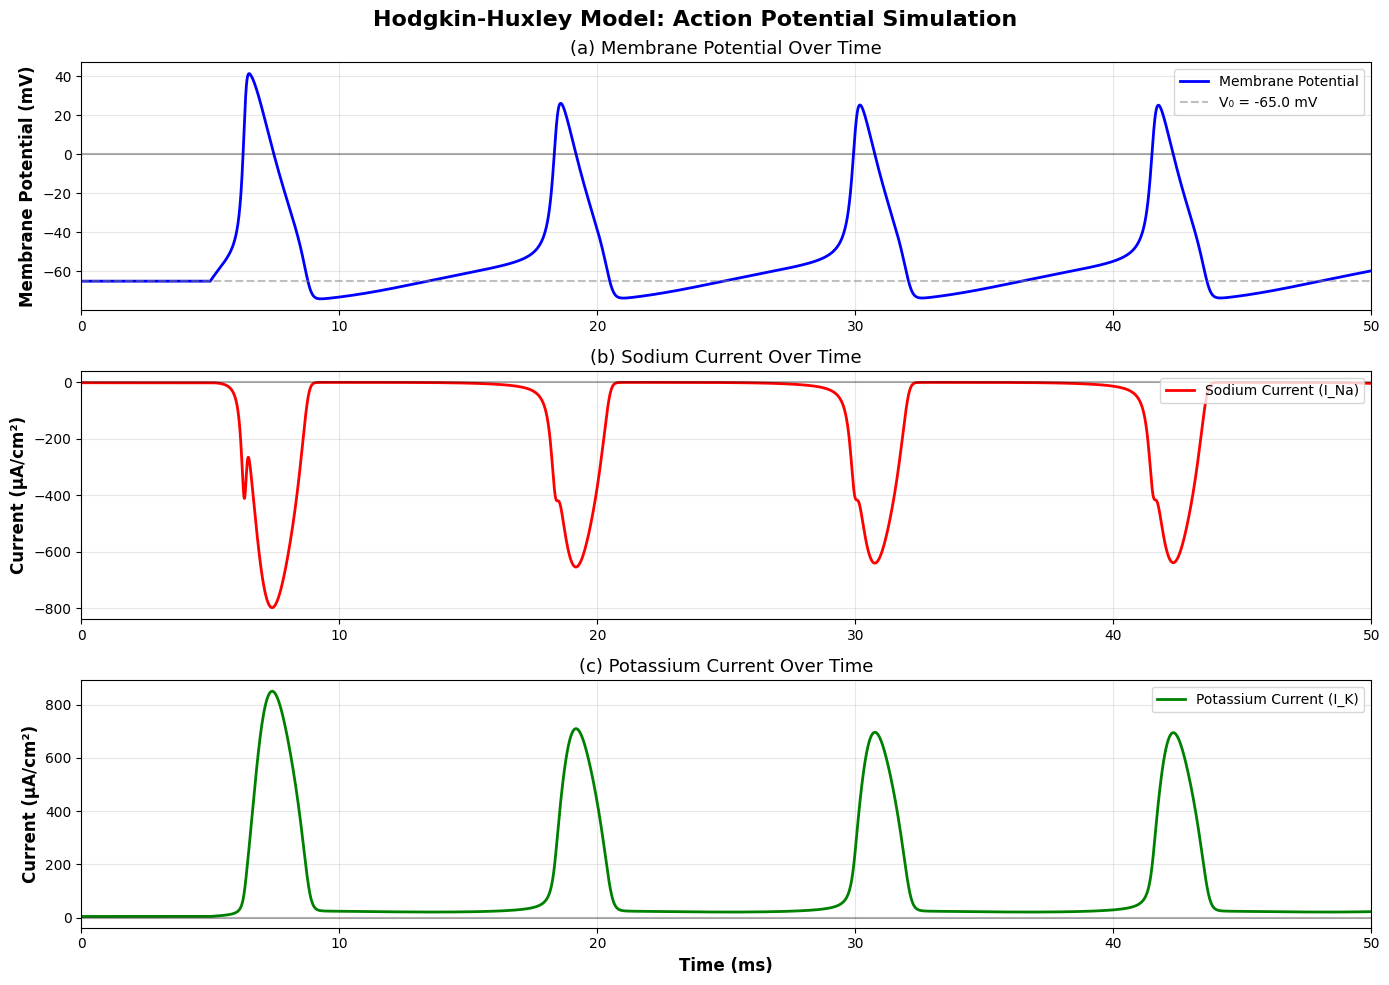

✓ Đã vẽ biểu đồ V, I_Na, I_K theo yêu cầu đề bài


In [7]:
"""
============================================================================
PHẦN 6: VẼ BIỂU ĐỒ KẾT QUẢ (Theo yêu cầu đề bài)
============================================================================
"""

fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Hodgkin-Huxley Model: Action Potential Simulation', 
             fontsize=16, fontweight='bold')

# Subplot 1: Điện thế màng (V)
axes[0].plot(t, V, 'b-', linewidth=2, label='Membrane Potential')
axes[0].axhline(y=V_0, color='gray', linestyle='--', alpha=0.5, label=f'V₀ = {V_0} mV')
axes[0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[0].set_ylabel('Membrane Potential (mV)', fontsize=12, fontweight='bold')
axes[0].set_title('(a) Membrane Potential Over Time', fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper right')
axes[0].set_xlim([0, t_end])

# Subplot 2: Dòng Sodium (I_Na)
axes[1].plot(t, I_Na_array, 'r-', linewidth=2, label='Sodium Current (I_Na)')
axes[1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1].set_ylabel('Current (μA/cm²)', fontsize=12, fontweight='bold')
axes[1].set_title('(b) Sodium Current Over Time', fontsize=13)
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper right')
axes[1].set_xlim([0, t_end])

# Subplot 3: Dòng Potassium (I_K)
axes[2].plot(t, I_K_array, 'g-', linewidth=2, label='Potassium Current (I_K)')
axes[2].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[2].set_xlabel('Time (ms)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Current (μA/cm²)', fontsize=12, fontweight='bold')
axes[2].set_title('(c) Potassium Current Over Time', fontsize=13)
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='upper right')
axes[2].set_xlim([0, t_end])

plt.tight_layout()
plt.show()

print("✓ Đã vẽ biểu đồ V, I_Na, I_K theo yêu cầu đề bài")

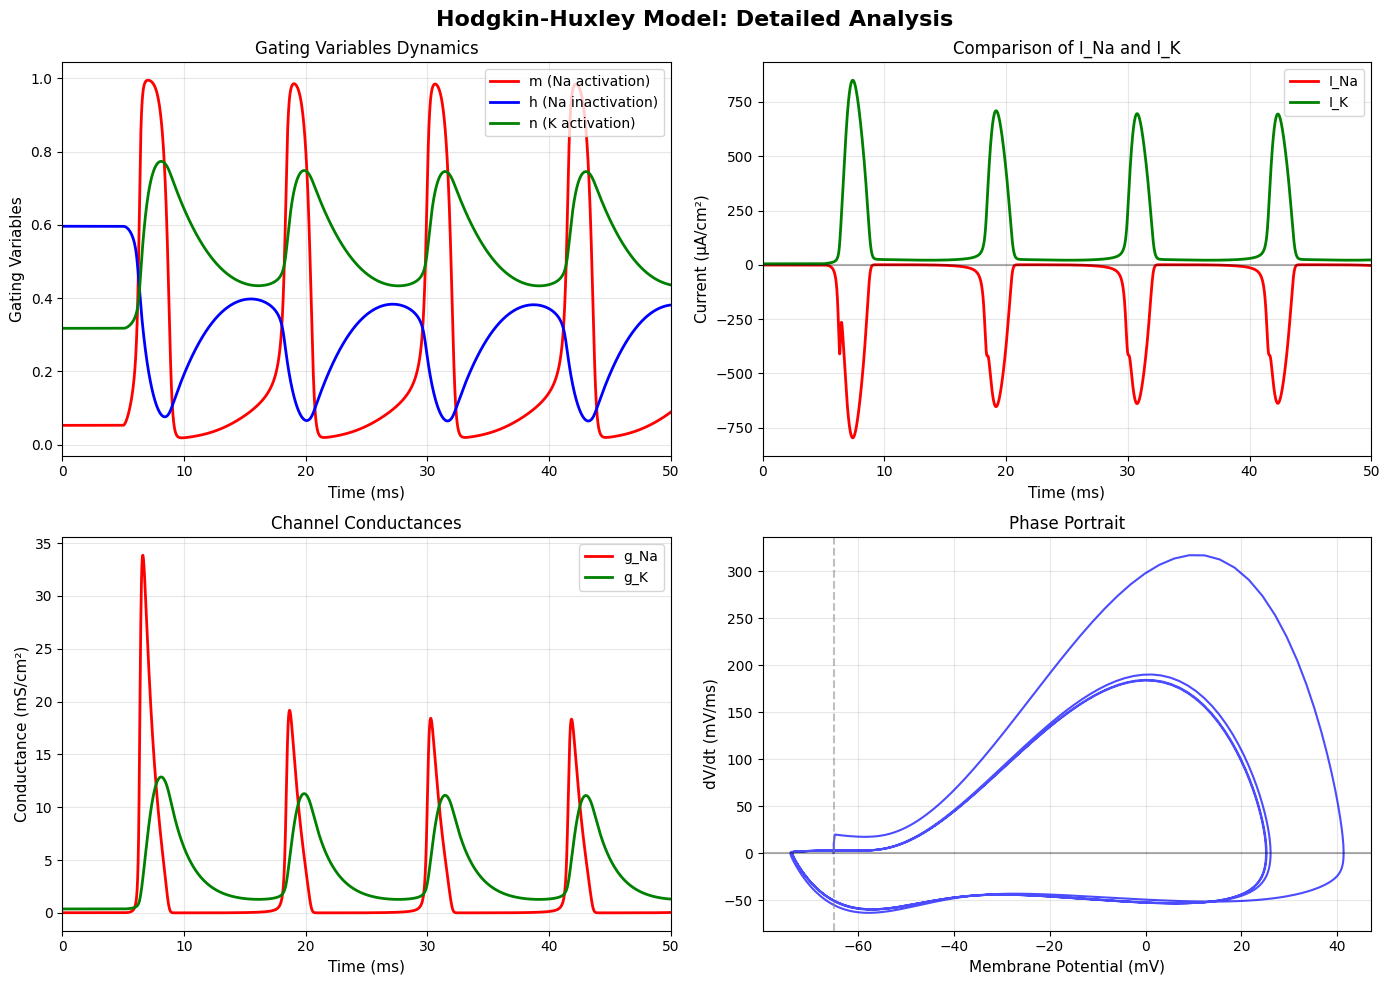

In [8]:
"""
============================================================================
BIỂU ĐỒ PHÂN TÍCH CHI TIẾT
============================================================================
"""

fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))
fig2.suptitle('Hodgkin-Huxley Model: Detailed Analysis', 
              fontsize=16, fontweight='bold')

# Subplot 1: Tất cả các biến trạng thái
axes2[0, 0].plot(t, m, 'r-', linewidth=2, label='m (Na activation)')
axes2[0, 0].plot(t, h, 'b-', linewidth=2, label='h (Na inactivation)')
axes2[0, 0].plot(t, n, 'g-', linewidth=2, label='n (K activation)')
axes2[0, 0].set_xlabel('Time (ms)', fontsize=11)
axes2[0, 0].set_ylabel('Gating Variables', fontsize=11)
axes2[0, 0].set_title('Gating Variables Dynamics', fontsize=12)
axes2[0, 0].legend()
axes2[0, 0].grid(True, alpha=0.3)
axes2[0, 0].set_xlim([0, t_end])

# Subplot 2: So sánh I_Na và I_K
axes2[0, 1].plot(t, I_Na_array, 'r-', linewidth=2, label='I_Na')
axes2[0, 1].plot(t, I_K_array, 'g-', linewidth=2, label='I_K')
axes2[0, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes2[0, 1].set_xlabel('Time (ms)', fontsize=11)
axes2[0, 1].set_ylabel('Current (μA/cm²)', fontsize=11)
axes2[0, 1].set_title('Comparison of I_Na and I_K', fontsize=12)
axes2[0, 1].legend()
axes2[0, 1].grid(True, alpha=0.3)
axes2[0, 1].set_xlim([0, t_end])

# Subplot 3: Độ dẫn của các kênh
g_Na_array = g_Na * (m**3) * h
g_K_array = g_K * (n**4)
axes2[1, 0].plot(t, g_Na_array, 'r-', linewidth=2, label='g_Na')
axes2[1, 0].plot(t, g_K_array, 'g-', linewidth=2, label='g_K')
axes2[1, 0].set_xlabel('Time (ms)', fontsize=11)
axes2[1, 0].set_ylabel('Conductance (mS/cm²)', fontsize=11)
axes2[1, 0].set_title('Channel Conductances', fontsize=12)
axes2[1, 0].legend()
axes2[1, 0].grid(True, alpha=0.3)
axes2[1, 0].set_xlim([0, t_end])

# Subplot 4: Phase plot (V vs dV/dt)
dVdt = np.gradient(V, dt)
axes2[1, 1].plot(V, dVdt, 'b-', linewidth=1.5, alpha=0.7)
axes2[1, 1].set_xlabel('Membrane Potential (mV)', fontsize=11)
axes2[1, 1].set_ylabel('dV/dt (mV/ms)', fontsize=11)
axes2[1, 1].set_title('Phase Portrait', fontsize=12)
axes2[1, 1].grid(True, alpha=0.3)
axes2[1, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes2[1, 1].axvline(x=V_0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## GIẢI THÍCH VAI TRÒ CỦA I_Na VÀ I_K TRONG ACTION POTENTIAL

### 1. TRẠNG THÁI NGHỈ (RESTING STATE) - Trước t = 5ms

- Điện thế màng: V ≈ -65 mV (điện thế nghỉ)
- I_Na ≈ 0: Kênh Na đóng (m thấp, h cao)
- I_K ≈ 0: Kênh K đóng (n thấp)
- Màng ở trạng thái cân bằng

### 2. PHA DEPOLARIZATION (KHỬ CỰC) - Khoảng t = 5-8ms

**★ VAI TRÒ CHÍNH: DÒNG SODIUM (I_Na)**

- Step Input (20 μA/cm²) tại t=5ms → V tăng nhẹ
- Khi V đạt ngưỡng (-55 mV):
  - Kênh Na mở nhanh (m↑ tăng nhanh)
  - Na⁺ đổ vào tế bào (I_Na < 0, dòng vào)
  - V tăng mạnh (depolarization)
- I_Na đạt peak âm lớn (~-800 μA/cm²)
- Điện thế màng tăng từ -65mV → +40mV

**⚠️ Cơ chế phản hồi dương (Positive feedback):**
- V tăng → Nhiều kênh Na mở → I_Na tăng → V tăng thêm

**✓ KẾT LUẬN: I_Na là nguyên nhân chính gây ra DEPOLARIZATION**

### 3. PEAK VÀ INACTIVATION - Khoảng t = 8-10ms

- V đạt đỉnh (~+40 mV)
- Kênh Na bắt đầu bất hoạt (h↓ giảm nhanh)
- I_Na giảm về 0 (kênh Na đóng)
- Đồng thời, kênh K bắt đầu mở (n↑ tăng)

### 4. PHA REPOLARIZATION (TÁI PHÂN CỰC) - Khoảng t = 10-20ms

**★ VAI TRÒ CHÍNH: DÒNG POTASSIUM (I_K)**

- Kênh K mở rộng (n đạt giá trị cao)
- K⁺ thoát ra ngoài tế bào (I_K > 0, dòng ra)
- I_K đạt peak dương (~+850 μA/cm²)
- Điện thế màng giảm từ +40mV → -80mV

**⚠️ Cơ chế khôi phục:**
- Kênh K mở → K⁺ ra ngoài → V giảm → Về điện thế nghỉ

**✓ KẾT LUẬN: I_K là nguyên nhân chính gây ra REPOLARIZATION**

### 5. PHA HYPERPOLARIZATION (QUÁ PHÂN CỰC) - Khoảng t = 20-30ms

- Kênh K vẫn còn mở một phần (n giảm chậm)
- I_K dương nhỏ → V < V_rest (-80mV)
- Trạng thái tạm thời âm hơn điện thế nghỉ

### 6. KHÔI PHỤC (RECOVERY) - Sau t = 30ms

- Kênh K đóng dần (n → giá trị nghỉ)
- I_K → 0
- V trở về điện thế nghỉ (-65mV)
- Kênh Na phục hồi khỏi inactivation (h tăng về giá trị nghỉ)
- Sẵn sàng cho action potential tiếp theo

---

## TÓM TẮT VAI TRÒ

| GIAI ĐOẠN | VAI TRÒ CHÍNH |
|-----------|---------------|
| **DEPOLARIZATION** (Khử cực) | **I_Na** (âm, lớn) → Na⁺ vào → V tăng nhanh<br>Cơ chế: Phản hồi dương, mở nhanh |
| **REPOLARIZATION** (Tái phân cực) | **I_K** (dương, lớn) → K⁺ ra → V giảm về nghỉ<br>Cơ chế: Mở chậm, đóng chậm |

---

## ĐẶC ĐIỂM ĐỘNG HỌC

**I_Na (Sodium Current):**
- Kích hoạt NHANH (m tăng nhanh khi V tăng)
- Bất hoạt NHANH (h giảm nhanh sau khi kích hoạt)
- Dòng VÀO tế bào (I_Na < 0)
- Đóng vai trò chính trong DEPOLARIZATION

**I_K (Potassium Current):**
- Kích hoạt CHẬM (n tăng chậm)
- Đóng CHẬM (n giảm chậm)
- Dòng RA khỏi tế bào (I_K > 0)
- Đóng vai trò chính trong REPOLARIZATION

---

## Ý NGHĨA SINH LÝ

- Sự kết hợp I_Na (nhanh) và I_K (chậm) tạo ra dạng sóng action potential
- I_Na cho phép truyền tín hiệu nhanh
- I_K đảm bảo màng quay về trạng thái nghỉ và sẵn sàng cho xung tiếp theo
- Cơ chế này là nền tảng cho việc truyền tín hiệu thần kinh trong não


In [9]:
"""
============================================================================
PHẦN 7: THỐNG KÊ KẾT QUẢ MÔ PHỎNG
============================================================================
"""

print("="*80)
print("THỐNG KÊ KẾT QUẢ MÔ PHỎNG")
print("="*80)
print()

# Tìm các điểm đặc trưng
idx_peak = np.argmax(V)
t_peak = t[idx_peak]
V_peak = V[idx_peak]

idx_I_Na_min = np.argmin(I_Na_array)
t_I_Na_min = t[idx_I_Na_min]
I_Na_min = I_Na_array[idx_I_Na_min]

idx_I_K_max = np.argmax(I_K_array)
t_I_K_max = t[idx_I_K_max]
I_K_max = I_K_array[idx_I_K_max]

print("CÁC ĐIỂM ĐẶC TRƯNG:")
print(f"  1. Điện thế màng:")
print(f"     - Điện thế nghỉ: {V_0} mV")
print(f"     - Điện thế đỉnh: {V_peak:.2f} mV tại t = {t_peak:.2f} ms")
print(f"     - Biên độ action potential: {V_peak - V_0:.2f} mV")
print()
print(f"  2. Dòng Sodium (I_Na):")
print(f"     - Giá trị âm cực đại: {I_Na_min:.2f} μA/cm² tại t = {t_I_Na_min:.2f} ms")
print(f"     - Tốc độ kích hoạt: Nhanh (~2-3 ms)")
print()
print(f"  3. Dòng Potassium (I_K):")
print(f"     - Giá trị dương cực đại: {I_K_max:.2f} μA/cm² tại t = {t_I_K_max:.2f} ms")
print(f"     - Tốc độ kích hoạt: Chậm (~8-10 ms)")
print()

print("="*80)
print("KẾT LUẬN")
print("="*80)
print()
print("✓ Đã hoàn thành mô phỏng mô hình Hodgkin-Huxley theo yêu cầu đề bài:")
print("  1. ✓ Định nghĩa tất cả tham số cần thiết")
print("  2. ✓ Định nghĩa 6 hàm tốc độ (α_m, β_m, α_h, β_h, α_n, β_n)")
print("  3. ✓ Sử dụng V₀ = -65 mV")
print("  4. ✓ Áp dụng Step Input I_ext = 20 μA/cm²")
print("  5. ✓ Vẽ biểu đồ V, I_Na, I_K theo thời gian")
print("  6. ✓ Giải thích vai trò I_Na và I_K trong depolarization và repolarization")
print()
print("="*80)

THỐNG KÊ KẾT QUẢ MÔ PHỎNG

CÁC ĐIỂM ĐẶC TRƯNG:
  1. Điện thế màng:
     - Điện thế nghỉ: -65.0 mV
     - Điện thế đỉnh: 41.29 mV tại t = 6.51 ms
     - Biên độ action potential: 106.29 mV

  2. Dòng Sodium (I_Na):
     - Giá trị âm cực đại: -797.44 μA/cm² tại t = 7.40 ms
     - Tốc độ kích hoạt: Nhanh (~2-3 ms)

  3. Dòng Potassium (I_K):
     - Giá trị dương cực đại: 850.28 μA/cm² tại t = 7.40 ms
     - Tốc độ kích hoạt: Chậm (~8-10 ms)

KẾT LUẬN

✓ Đã hoàn thành mô phỏng mô hình Hodgkin-Huxley theo yêu cầu đề bài:
  1. ✓ Định nghĩa tất cả tham số cần thiết
  2. ✓ Định nghĩa 6 hàm tốc độ (α_m, β_m, α_h, β_h, α_n, β_n)
  3. ✓ Sử dụng V₀ = -65 mV
  4. ✓ Áp dụng Step Input I_ext = 20 μA/cm²
  5. ✓ Vẽ biểu đồ V, I_Na, I_K theo thời gian
  6. ✓ Giải thích vai trò I_Na và I_K trong depolarization và repolarization

